# 1. Imports

In [3]:
import os
from notebook_init import init_notebook_path
import sys

# Get project root path
project_root = init_notebook_path()

# Set environment variable for Ray workers to find the app module
os.environ["PYTHONPATH"] = f"{project_root}:{os.environ.get('PYTHONPATH', '')}"

#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Python path properly configured. Project root added: /app


In [4]:
import warnings
import numpy as np
import ray


from app.utils import unwrap_angles, calculate_euler_angles_list
from hyperopt import hp
from ray import tune
from sklearn.model_selection import KFold
from ray.tune.search.hyperopt import HyperOptSearch
from app.workflow.utils import calculate_score_between, add_predicted_transitions_to_df, calculate_scores_sec_metric, calculate_overall_score, align_min_max_lists_counts_order, get_score_for_intervals, process_turns_with_restricted_distances, find_midpoints_with_weights, find_midpoints, align_min_max_lists, label_apex_list, label_apex, filter_extremes, read_files_recursive, read_files, split_data_granular, smooth_data, remove_outliers, merge_close_integers, find_closest_actuals, find_tp_fp_fn_tn, calculate_performance_metrics, append_predictions_df_new
from app.workflow.gradientdescent import gradient_descent_full
from sklearn.model_selection import train_test_split
from pandas.errors import SettingWithCopyWarning


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# 2. Data loading and preprocessing

In [5]:
labeled_data = read_files_recursive(path = os.path.join(project_root, "data/turns"))
split_on = "Orientation"
orientation_dfs = split_data_granular(labeled_data, split_on=split_on)
transformed_dfs = calculate_euler_angles_list(orientation_dfs)
unwraped_data = unwrap_angles(transformed_dfs)
smoothed_orientation_dfs = smooth_data(unwraped_data, window_size=10)
apex_dfs = label_apex_list(smoothed_orientation_dfs)


Processing: /app/data/turns/HONOR_8X/2024-02-17/1.csv
Processing: /app/data/turns/HONOR_8X/2024-02-17/2.csv
Processing: /app/data/turns/HONOR_8X/2024-02-17/3.csv
Processing: /app/data/turns/HONOR_8X/2024-02-17/4.csv
Processing: /app/data/turns/HONOR_8X/2024-02-17/5.csv
Processing: /app/data/turns/HONOR_8X/2024-02-17/6.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/1_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/2_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/3_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/4_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/5_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/6_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-02-24/7_sp.csv
Processing: /app/data/turns/HONOR_8X/2024-03-19/1.csv
Processing: /app/data/turns/HONOR_8X/2024-03-19/10.csv
Processing: /app/data/turns/HONOR_8X/2024-03-19/11.csv
Processing: /app/data/turns/HONOR_8X/2024-03-19/12.csv
Processing: /app/data/turns/HONOR_8X/2024-03-19/13_sp.csv


# 3. Define ray function to run algorithm
#### mode is used to define application for algorithm.  
#### mode = "between", "apex_percentage", "turn_coverage" response for use cases presented in pdf in the same order

In [ ]:
def process_combination_ray(combination, train, col= "yaw", random_seed = 42, mode = "regular", detail_metric = False):
    # TODO: What is the purpose of each metric?
    # TODO: Are metrics meaningful at each phase (filtering, prediction, evaluation)?
    if mode != "regular" and mode != "between" and mode != "apex_percentage" and mode != "turn_coverage":
        raise ValueError("Mode must be 'regular' or 'between'")
    combination["Gradient_Steps"] = int(combination["Gradient_Steps"])
    combination["merge_threshold"] = int(combination["merge_threshold"])
    combination["number_of_points"] = int(combination["number_of_points"])
    combination["Threshold"] = int(combination["Threshold"])
    np.random.seed(random_seed)  # Set the random seed inside the remote function

    total_TP = []
    total_FP = []
    total_FN = []
    total_TN = []


    total_int_TP = 0
    total_int_FP = 0
    total_int_FN = 0
    total_int_TN = 0

    # *for metrics apex percentage and turn coverage
    total_score = 0
    total_lenght = 0
    for df in train:
        start_indices = np.random.randint(1, len(df), size=combination["number_of_points"])

        predicted_mins, predicted_maxs = gradient_descent_full(df, start_indices, learning_rate=combination['Gradient_LR'], steps=combination["Gradient_Steps"], momentum=combination['Gradient_Momentum'], selected_col= col, printing=False)

        unique_predictions_mins, counts_mins = np.unique(predicted_mins, return_counts=True)
        unique_predictions_maxs, counts_maxs = np.unique(predicted_maxs, return_counts=True)

        new_mins, new_counts_min = merge_close_integers(unique_predictions_mins, counts_mins, threshold = combination['merge_threshold'])
        new_max, new_counts_max = merge_close_integers(unique_predictions_maxs, counts_maxs, threshold = combination['merge_threshold'])

        new_filtered_mins, new_filtered_mins_counts = remove_outliers(new_mins, new_counts_min, df, multiplier= combination['outliers_multiplier'], selected_col=col, boundary="upper")
        new_filtered_max, new_filtered_maxs_counts = remove_outliers(new_max, new_counts_max, df, combination['outliers_multiplier'], selected_col=col, boundary="lower")

        important_min, important_min_counts = filter_extremes(new_filtered_mins, new_filtered_mins_counts,threshold_int=combination['Threshold'])
        important_max, important_max_counts = filter_extremes(new_filtered_max, new_filtered_maxs_counts,threshold_int=combination['Threshold'])
        
        if mode == "regular":
            trimmed_mins, trimmed_mins_counts, trimmed_maxs, trimmed_maxs_counts = align_min_max_lists(important_min, important_min_counts, important_max, important_max_counts)
            new_trimed_mins, new_trimed_maxs = find_midpoints(trimmed_mins, trimmed_maxs)
            
            df_forecast = append_predictions_df_new(df, new_trimed_mins, new_trimed_maxs) 
            df_forecast_closest = find_closest_actuals(df_forecast)

            df_TP, df_FP, df_FN, tn, custom_score = find_tp_fp_fn_tn(df_forecast=df_forecast_closest, margin_of_error = 10)
            total_TP.append(df_TP)
            total_FP.append(df_FP)
            total_FN.append(df_FN)
            total_TN.append(tn)
        elif mode == "between": # 1st metric
            trimmed_mins, trimmed_mins_counts, trimmed_maxs, trimmed_maxs_counts = align_min_max_lists(important_min, important_min_counts, important_max, important_max_counts)
            new_trimed_mins, new_trimed_maxs = find_midpoints(trimmed_mins, trimmed_maxs)
            
            df_forecast = append_predictions_df_new(df, new_trimed_mins, new_trimed_maxs) 
            df_forecast_closest = find_closest_actuals(df_forecast)
            
            int_TP, int_FP, int_FN, int_tn = calculate_score_between(df_forecast=df_forecast_closest)
            total_int_TP += int_TP
            total_int_FP += int_FP
            total_int_FN += int_FN
            total_int_TN += int_tn
        elif mode == "apex_percentage": # 2nd metric
            trimmed_mins, trimmed_mins_counts, trimmed_maxs, trimmed_maxs_counts = align_min_max_lists(important_min, important_min_counts, important_max, important_max_counts)
            new_trimed_mins, new_mins_counts, new_trimed_maxs, new_max_counts = find_midpoints_with_weights(trimmed_mins, trimmed_mins_counts, trimmed_maxs, trimmed_maxs_counts)
            
            df_forecast = append_predictions_df_new(df, new_trimed_mins, new_trimed_maxs, new_mins_counts, new_max_counts) 
            df_forecast_closest = find_closest_actuals(df_forecast)
            
            inv_df = process_turns_with_restricted_distances(df_forecast_closest)
            score_df = calculate_scores_sec_metric(inv_df)
            df_scores_sum, df_lenghts = calculate_overall_score(score_df)
            total_score += df_scores_sum
            total_lenght += df_lenghts
        
        elif mode == "turn_coverage": # 3rd metric
            new_method_mins, new_method_max = align_min_max_lists_counts_order(important_min, important_max, important_min_counts, important_max_counts)
            inteval_df = add_predicted_transitions_to_df(df, new_method_mins, new_method_max)
            df_scores_sum, df_lenghts = get_score_for_intervals(inteval_df)
            total_score += df_scores_sum
            total_lenght += df_lenghts
            


    if mode == "regular":
        total_TP_rows = sum(len(df) for df in total_TP)
        total_FP_rows = sum(len(df) for df in total_FP)
        total_FN_rows = sum(len(df) for df in total_FN)
        total_TN_num = sum(total_TN)
        metrics = calculate_performance_metrics(total_TP_rows, total_FP_rows, total_FN_rows, total_TN_num)
        return metrics['Overall F1 Score']

    elif mode == "between":
        metrics = calculate_performance_metrics(total_int_TP, total_int_FP, total_int_FN, total_int_TN)
        if detail_metric:
            return metrics
        return metrics['Overall F1 Score']
    elif mode == "apex_percentage":
        return total_score/total_lenght
    elif mode == "turn_coverage":
        return total_score/total_lenght


def calculate_score_train(config, train):


    score = process_combination_ray(config, train, "yaw", 42, "regular") #between

    tune.report(score=score)

# 4. Define search space for algorithm

In [7]:

def generate_values(start, stop, step):
    return list(range(start, stop + 1, step))


gradient_lr_range = (0.01, 0.1)
gradient_steps_range = (100, 500) 
gradient_steps_step = 10  
momentum_range = (0.90, 0.999)
merge_threshold_range = (5, 20) 
outliers_range = (2.0, 5.0)
number_of_points_range = (100, 1000)  
number_of_points_step = 100 
threshold_range = (0, 20) 


gradient_steps_values = generate_values(gradient_steps_range[0], gradient_steps_range[1], gradient_steps_step)
number_of_points_values = generate_values(number_of_points_range[0], number_of_points_range[1], number_of_points_step)

space = {
    'Gradient_LR': hp.loguniform('Gradient_LR', np.log(gradient_lr_range[0]), np.log(gradient_lr_range[1])),
    'Gradient_Steps': hp.choice('Gradient_Steps', gradient_steps_values),  
    'Gradient_Momentum': hp.uniform('Gradient_Momentum', *momentum_range),  
    'merge_threshold': hp.randint('merge_threshold', merge_threshold_range[1] - merge_threshold_range[0]) + merge_threshold_range[0], 
    'outliers_multiplier': hp.uniform('outliers_multiplier', *outliers_range), 
    'number_of_points': hp.choice('number_of_points', number_of_points_values),  
    'Threshold': hp.randint('Threshold', threshold_range[1] - threshold_range[0]) + threshold_range[0] 
}

In [8]:
ray.shutdown()

# 5. Hyperparameter tuning

In [9]:
# Define a cross-validation wrapper
def calculate_score_cv(config, train, n_splits=5, random_seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    f1_scores = []

    for train_index, val_index in kf.split(train):
        # Split data into train and validation folds
        train_fold = [train[i] for i in train_index]
        val_fold = [train[i] for i in val_index]

        np.random.seed(random_seed) 

        #* choose metric from: between, apex_percentage, turn_coverage
        # Train on the train_fold
        process_combination_ray(config, train_fold, "yaw", random_seed, "between")

        # Evaluate on the val_fold
        val_score = process_combination_ray(config, val_fold, "yaw", random_seed, "between")
        f1_scores.append(val_score)

    # Calculate mean F1 score across all folds
    mean_f1_score = np.mean(f1_scores)

    # Report the mean score for this configuration
    tune.report(score=mean_f1_score)

# Initialize Ray
random_seed = 42
train, test = train_test_split(apex_dfs, test_size=0.2, random_state=random_seed)

#! ray init this way due to `demo/`folder location
ray.init(
    runtime_env={
        "env_vars": {"PYTHONPATH": os.environ["PYTHONPATH"]},
        "py_modules": [os.path.join(project_root, "app")]
    }
)

# Trainable with cross-validation
trainable_with_cv = lambda config: calculate_score_cv(config, train)

# Define the HyperOptSearch
hyperopt_search = HyperOptSearch(
    metric="score",  # Target metric
    mode="max",      # Optimization mode
    space=space,      # Search space
    random_state_seed = random_seed
)

experiment_name = "test"

analysis = tune.run(
    trainable_with_cv,
    search_alg=hyperopt_search,
    num_samples=10,
    resources_per_trial={"cpu": 1},
    metric="score",
    mode="max",
    local_dir="./ray_results", 
    name=experiment_name,        # Use a fixed folder name for the experiment
    keep_checkpoints_num=3,     
    resume="AUTO",              
)


# Shutdown Ray
ray.shutdown()

2025-05-24 20:10:36,488	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.74gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-05-24 20:10:38,334	INFO worker.py:1621 -- Started a local Ray instance.
2025-05-24 20:10:38,867	INFO packaging.py:518 -- Creating a file package for local directory '/app/app'.
2025-05-24 20:10:40,253	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_31b9b6da8ceb474d.zip' (0.23MiB) to Ray cluster...
2025-05-24 20:10:40,274	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_31b9b6da8ceb474d.zip'.
2025-05-24 20:10:53,412	INFO tune.py:657 -- [output] This uses the lega

2025-05-24 20:10:54,384	INFO experiment_state.py:430 -- No local checkpoint was found. Ray Tune will now start a new experiment.
(<lambda> pid=2405) /tmp/ray/session_2025-05-24_20-10-31_524481_1236/runtime_resources/py_modules_files/_ray_pkg_31b9b6da8ceb474d/app/workflow/utils.py:364: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
(<lambda> pid=2405)   for idx, value in actual_series.iteritems():
(<lambda> pid=2405) /tmp/ray/session_2025-05-24_20-10-31_524481_1236/runtime_resources/py_modules_files/_ray_pkg_31b9b6da8ceb474d/app/workflow/utils.py:364: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
(<lambda> pid=2405)   for idx, value in actual_series.iteritems():
(<lambda> pid=2405) /tmp/ray/session_2025-05-24_20-10-31_524481_1236/runtime_resources/py_modules_files/_ray_pkg_31b9b6da8ceb474d/app/workflow/utils.py:364: FutureWarning: iteritems is deprecated and will be removed in a fu

Trial name,score
lambda_131db912,0.88157
lambda_206dd0da,0.895782
lambda_73d90832,0.910653
lambda_88fa7f35,0.871802
lambda_a766d946,0.898832
lambda_ad7adbcd,0.899857
lambda_c2733116,0.891168
lambda_c5b2df5a,0.863613
lambda_d3ef575d,0.87879
lambda_f47db5f5,0.93516


(<lambda> pid=2521) /tmp/ray/session_2025-05-24_20-10-31_524481_1236/runtime_resources/py_modules_files/_ray_pkg_31b9b6da8ceb474d/app/workflow/utils.py:364: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead. [repeated 167x across cluster]
(<lambda> pid=2521)   for idx, value in actual_series.iteritems(): [repeated 167x across cluster]
(<lambda> pid=2405) /tmp/ray/session_2025-05-24_20-10-31_524481_1236/runtime_resources/py_modules_files/_ray_pkg_31b9b6da8ceb474d/app/workflow/utils.py:364: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead. [repeated 135x across cluster]
(<lambda> pid=2405)   for idx, value in actual_series.iteritems(): [repeated 135x across cluster]
(<lambda> pid=2466) /tmp/ray/session_2025-05-24_20-10-31_524481_1236/runtime_resources/py_modules_files/_ray_pkg_31b9b6da8ceb474d/app/workflow/utils.py:364: FutureWarning: iteritems is deprecated and will be removed in a future 

# 6. Testing

In [10]:
# Train final model on the train set
best_config = analysis.best_config
final_score = process_combination_ray(best_config, train, "yaw", random_seed, "between", detail_metric=False)

# Evaluate final model on the test set
test_score = process_combination_ray(best_config, test, "yaw", random_seed, "between", detail_metric=False)


In [11]:
final_score

0.9356223175965666

In [12]:
test_score

0.9312169312169312

# 7. Find_peaks function

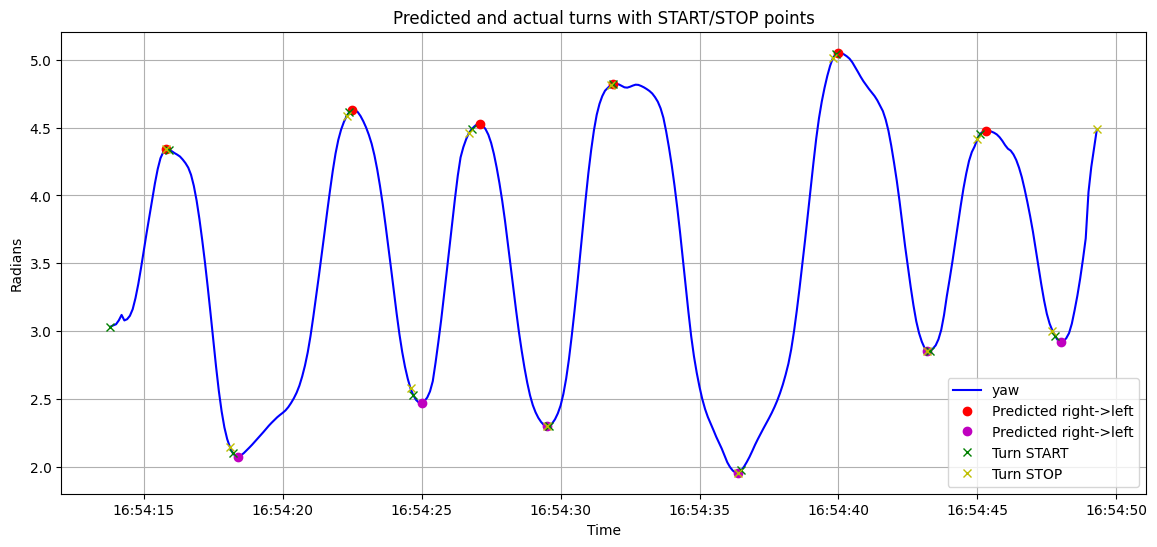

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

df = apex_dfs[0]

y = df['yaw'].values
x = df.index

# Detection of predicted peaks
prominence_val = 0.3
distance_val = 20
predicted_peaks, _ = find_peaks(y, prominence=prominence_val, distance=distance_val)
minima_indices, _ = find_peaks(-y, prominence=prominence_val, distance=distance_val)

# True turns
true_peaks = df.index[(df['Behavior'].isin(['left', 'right']))].tolist()
positions = df.index.get_indexer_for(true_peaks)

# START/STOP moments
start_indices = df.index[(df['Behavior'].isin(['left', 'right'])) & (df['Status'] == 'START')].tolist()
stop_indices = df.index[(df['Behavior'].isin(['left', 'right'])) & (df['Status'] == 'STOP')].tolist()
start_pos = df.index.get_indexer_for(start_indices)
stop_pos = df.index.get_indexer_for(stop_indices)

plt.figure(figsize=(14, 6))
plt.plot(x, y, label='yaw', color='blue')
plt.plot(x[predicted_peaks], y[predicted_peaks], 'ro', label='Predicted right->left')
plt.plot(x[minima_indices], y[minima_indices], 'mo', label='Predicted right->left')
plt.plot(x[start_pos], y[start_pos], 'gx', label='Turn START')
plt.plot(x[stop_pos], y[stop_pos], 'yx', label='Turn STOP')
plt.title("Predicted and actual turns with START/STOP points")
plt.xlabel("Time")
plt.ylabel("Radians")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.index

DatetimeIndex(['2024-03-21 16:54:13.800000', '2024-03-21 16:54:13.900000',
                      '2024-03-21 16:54:14', '2024-03-21 16:54:14.100000',
               '2024-03-21 16:54:14.200000', '2024-03-21 16:54:14.300000',
               '2024-03-21 16:54:14.400000', '2024-03-21 16:54:14.500000',
               '2024-03-21 16:54:14.600000', '2024-03-21 16:54:14.700000',
               ...
               '2024-03-21 16:54:48.400000', '2024-03-21 16:54:48.500000',
               '2024-03-21 16:54:48.600000', '2024-03-21 16:54:48.700000',
               '2024-03-21 16:54:48.800000', '2024-03-21 16:54:48.900000',
                      '2024-03-21 16:54:49', '2024-03-21 16:54:49.100000',
               '2024-03-21 16:54:49.200000', '2024-03-21 16:54:49.300000'],
              dtype='datetime64[ns]', name='time', length=356, freq=None)

In [ ]:
print(df.index.min())  
print(df.index.max()) 

2024-03-21 16:54:13.800000
2024-03-21 16:54:49.300000
